In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
sns.set(style='whitegrid')

In [14]:
#1. Load training data
input_path = 'data/train.csv'
train_data = pd.read_csv(input_path, index_col='Id')

#1a. Train Data rows x coulmns
print("Feature Matrix size : ", train_data.shape)

Feature Matrix size :  (1460, 80)


In [15]:
'''
2. Check if any train_data contain Missing/NULL values.
If yes, Fill Missing Data Appropriately.
'''
null_train_data = train_data.columns[train_data.isnull().any()]
missing_ratio = (train_data[null_train_data].isnull().sum()/len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
missing_data.sort_values(by='Missing Ratio',ascending=False)

,Missing Ratio
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageType,5.55
GarageYrBlt,5.55
GarageFinish,5.55
GarageQual,5.55


In [16]:
'''
3. Fill missing feature values
'''
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    train_data[col] = train_data[col].fillna('None')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType']:
    train_data[col] = train_data[col].fillna('None')
    
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    train_data[col] = train_data[col].fillna('None')
    
'''
No GarageYrBlt means no Garage. We cannot impute mean/median since it would 
incorrectly convey existence of Garage. same reasoning for MasVnrArea.
'''
for col in ['GarageYrBlt', 'MasVnrArea']:
    train_data[col] = train_data[col].fillna(0)
    
'''
Group data by neighborhood & imputed null LotFrontage columns with median of
grouped data.
'''
train_data['LotFrontage'] = train_data.groupby(['Neighborhood'])\
                    ['LotFrontage'].transform(lambda x : x.fillna(x.median()))

train_data['Electrical'] = \
    train_data['Electrical'].fillna(train_data['Electrical'].mode()[0])
    
null_train_data = train_data.columns[train_data.isnull().any()]
missing_ratio = (train_data[null_train_data].isnull().sum()/len(train_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
print(missing_data.sort_values(by='Missing Ratio',ascending=False))

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [17]:
# Numerical Variable Analysis
num_features = train_data.select_dtypes(include=np.number)
print('Number of Numerical features : ' + str(num_features.columns.size))

Number of Numerical features : 37


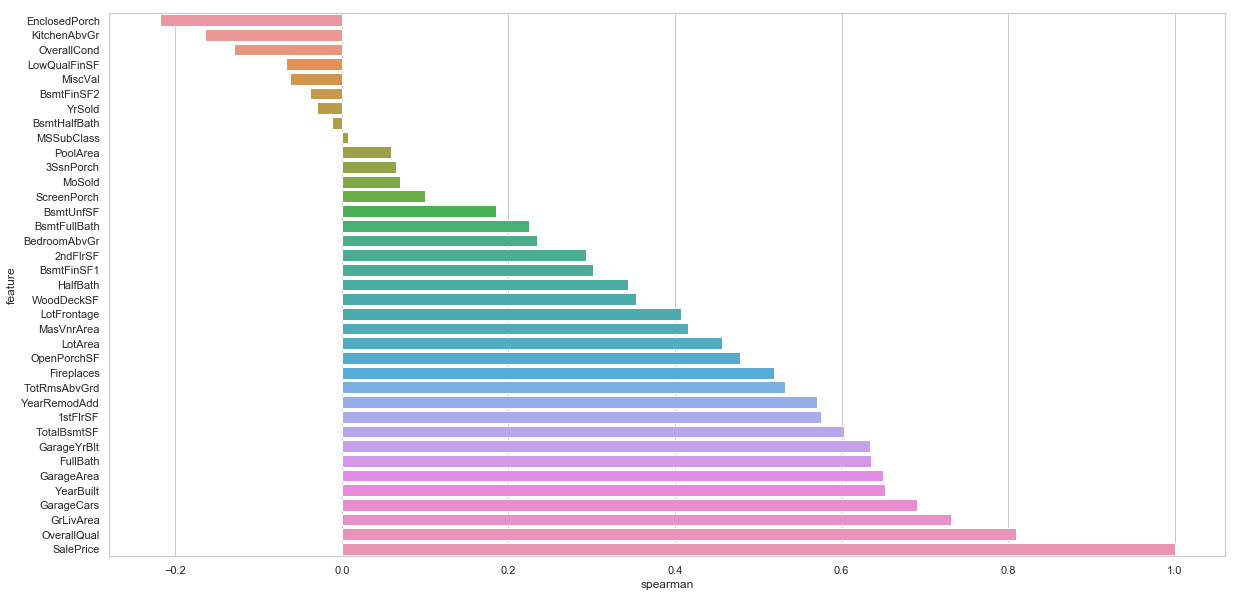

In [19]:
def find_spearman_corr(train_data, num_features_nms):
    sprearman_corr_df = pd.DataFrame()
    sprearman_corr_df['feature'] = num_features_nms
    sprearman_corr_df['spearman'] = \
            [train_data[f].corr(train_data['SalePrice'], 'spearman') \
             for f in num_features_nms]
    sprearman_corr_df = sprearman_corr_df.sort_values('spearman')
    plt.figure(figsize=(20,10))
    sns.barplot(data=sprearman_corr_df, y='feature', x='spearman')
    return sprearman_corr_df
    
sprearman_corr_df = find_spearman_corr(train_data, num_features.columns)

Text(0.5,1,'Spearman Correlation between features')

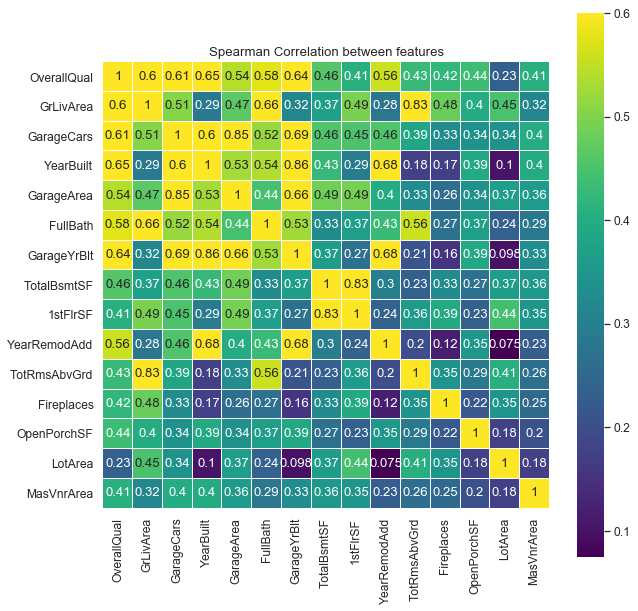

In [20]:
'''
Picked these features from correlation with SalePrice.
OverallQual, GrLivArea, GarageCars, YearBuilt, GarageArea, FullBath, GarageYrBlt,
TotalBsmtSF, 1stFlrSF, YearRemodAdd, TotRmsAbvGrd, Fireplaces, OpenPorchSF, 
LotArea, MasVnrArea.

Lets check correlation between one another.
'''

sig_num_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea',
               'FullBath', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd',
               'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', 'MasVnrArea']

spearman_corr = train_data[sig_num_cols].corr('spearman')

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))
sns.heatmap(spearman_corr, vmax=.6, linewidths=0.01, square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Spearman Correlation between features')

In [ ]:
'''
GrLivArea & TotRmsAbvGrd = 0.83
GarageCars & GarageArea = 0.85
YearBuilt & GarageYrBlt = 0.86
1stFlrSF & TotalBsmtSF = 0.83
YearRemodAdd with YearBuilt & GarageYrBlt = 0.68
GarageYrBlt & GarageArea = 0.66
GarageYrBlt & GarageCars = 0.69
FullBath & GrLivArea = 0.66


Exclude GrLivArea, GarageArea, GarageYrBlt, 1stFlrSF features owing to 
high correlation.

Final Numerical Features :
'OverallQual', 'GarageCars', 'YearBuilt','FullBath', 'TotalBsmtSF', 
'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', 
'MasVnrArea'
'''